<a href="https://colab.research.google.com/github/ProfessorAbraham/RAG-E/blob/main/RAG_QA_INSa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk


In [2]:
!pip install nltk

import json
import re
from collections import defaultdict

def process_amharic_jsonl(input_file, output_file, sentences_per_chunk=3, min_chunk_length=50):
    """
    Process JSONL file with Amharic content using paragraph chunking

    Args:
        input_file: Path to input JSONL file
        output_file: Path to output JSONL file
        sentences_per_chunk: Number of sentences per chunk
        min_chunk_length: Minimum character length for a valid chunk
    """

    def clean_amharic_text(text):
        """Clean and normalize Amharic text"""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # Normalize Ethiopic punctuation
        text = text.replace('።', '። ')  # Ensure space after full stop
        return text

    def split_amharic_sentences(text):
        """Split Amharic text into sentences"""
        sentences = []
        current_sentence = []

        for char in text:
            current_sentence.append(char)
            if char == '።':  # Amharic full stop
                sentence = ''.join(current_sentence).strip()
                if len(sentence) > 1:  # Ignore empty sentences
                    sentences.append(sentence)
                current_sentence = []

        # Add the last sentence if not empty
        if current_sentence:
            sentence = ''.join(current_sentence).strip()
            if len(sentence) > 1:
                sentences.append(sentence)

        return sentences

    def create_linked_chunks(sentences, chunk_size):
        """Create chunks with linking metadata"""
        chunks = []
        total_sentences = len(sentences)

        for i in range(0, total_sentences, chunk_size):
            chunk_end = min(i + chunk_size, total_sentences)
            chunk_text = ' '.join(sentences[i:chunk_end])

            # Skip chunks that are too short
            if len(chunk_text) < min_chunk_length:
                continue

            chunk_meta = {
                'chunk_num': len(chunks) + 1,
                'start_sentence': i + 1,
                'end_sentence': chunk_end,
                'total_sentences': total_sentences,
                'prev_chunk_id': f"{len(chunks)}" if len(chunks) > 0 else None,
                'next_chunk_id': None  # Will be set in next iteration
            }

            # Set next_chunk_id for previous chunk
            if len(chunks) > 0:
                chunks[-1]['metadata']['next_chunk_id'] = str(len(chunks))

            chunks.append({
                'text': chunk_text,
                'metadata': chunk_meta
            })

        return chunks

    # Process documents and write output
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:

        doc_counter = 0
        chunk_counter = 0

        for line in infile:
            try:
                data = json.loads(line)
                doc_counter += 1

                # Extract content with fallback to empty string
                content = data.get('content', '')
                if not content:
                    continue

                # Clean and process the Amharic text
                clean_content = clean_amharic_text(content)
                sentences = split_amharic_sentences(clean_content)

                # Create linked chunks
                chunks = create_linked_chunks(sentences, sentences_per_chunk)

                # Write each chunk to output
                for chunk in chunks:
                    output_data = {
                        'document_id': f"doc_{doc_counter}",
                        'chunk_id': f"chunk_{chunk_counter}",
                        'source_url': data.get('url', ''),
                        'scraper': data.get('scraper', ''),
                        'text': chunk['text'],
                        'metadata': {
                            **chunk['metadata'],
                            'original_metadata': {k: v for k, v in data.items()
                                                if k not in ['content', 'url', 'scraper']}
                        }
                    }

                    outfile.write(json.dumps(output_data, ensure_ascii=False) + '\n')
                    chunk_counter += 1

            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line[:100]}...")
                continue

        print(f"Processed {doc_counter} documents into {chunk_counter} chunks")
        print(f"Output saved to {output_file}")

# Example usage
input_file = '/content/extracted_data (5).jsonl'  # Change to your input path
output_file = '/content/chunked_output.jsonl'  # Change to desired output path

# Process with 3 sentences per chunk (adjust as needed)
process_amharic_jsonl(input_file, output_file, sentences_per_chunk=3)

Processed 169 documents into 10815 chunks
Output saved to /content/chunked_output.jsonl


In [3]:
# View first 3 chunks
!head -n 3 /content/chunked_output.jsonl

# Count total chunks
!wc -l /content/chunked_output.jsonl

{"document_id": "doc_1", "chunk_id": "chunk_0", "source_url": "http://www.fis.gov.et/media/%E1%8B%A8%E1%8D%8B%E1%8B%AD%E1%8A%93%E1%8A%95%E1%88%B5_%E1%8B%B0%E1%88%85%E1%8A%95%E1%8A%90%E1%89%B5_%E1%8A%A0%E1%8C%88%E1%88%8D%E1%8C%8D%E1%88%8E%E1%89%B5_%E1%8B%93%E1%88%98%E1%89%B3%E1%8B%8A_%E1%88%98%E1%8D%85%E1%88%90%E1%8D%8D_2014.pdf", "scraper": "Abraham", "text": "አመታዊ መጽሐፍ መስከረም 2015 ዓ . ም ማውጫ የአገልግሎቱ ተልዕኮ . 1 የአገልግሎቱ ራዕይ . 1 የአገልግሎቱ እሴቶች . 1 የአልግሎቱ ስልጣንና ተግባር . . የፋይናንስ ደህንነት አገልግሎት በ2014 በጀት ዓመት . . የአገር ውስጥ ትብብርና ቅንጅት . . የዓለም አቀፍ ትብብርና ቅንጅት . . የወንጀል ትንተና ሶፍትዌር ልማት አገልግሎቱ . . በአገልግሎቱ ለሀገር መከላከያ የተደረገ ሠራዊት ድጋፍ . . የግንዛቤ ማሳደግ ተግባራት . . በወንጀል ድርጊት የተገኘ ገንዘብ ንብረት ህጋዊ ማስመሰል . . የኮንትሮባንድ እና ሕገ - ወጥ የውጭ አገራት ገንዘብ ምንዛሪ ትስስር . . ተቋማዊ ቅንጅት የሚሻው የፋይናንስ ወንጀሎች መከላከልና መቆጣጠር . . የወንጀለኝነት ቅጣት ሳይተላለፍ ስለሚደረግ የንብረት ውርስ . . የአስቸኳይ ጊዜ አዋጅ እና የአገልግሎቱ አስተዋፅኦ . . ማህበረሰባዊ ንቃት የሚሸው የማኅበራዊ ሚዲያ አጠቃቀም . 30 ማውጫ 13 . በህግ የሰውነት መብት የተሰጣቸው የንግድ ተቋማት ለወንጀል ተግባር መጠቀሚያ እንዳይሆኑ . . ለትርፍ ያልተቋቋሙ ድርጅቶች ሽብርተኝነትን በገንዘብ መደገፍ ተጋ

In [4]:
# Sample code to load chunks for embedding
chunks = []
with open('/content/chunked_output.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        chunks.append(json.loads(line))
print(f"Loaded {len(chunks)} chunks for embedding")

Loaded 10815 chunks for embedding


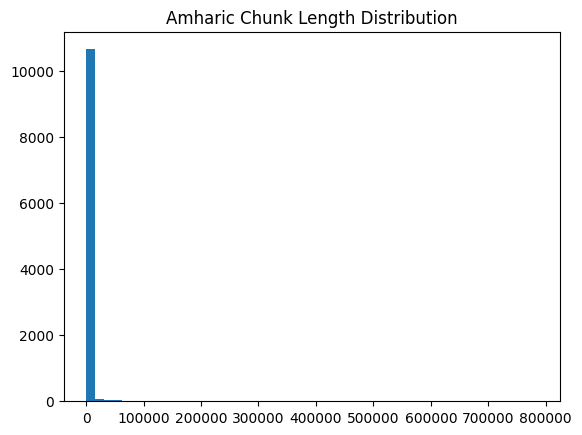

In [5]:
import matplotlib.pyplot as plt
chunk_lengths = [len(c['text']) for c in chunks]
plt.hist(chunk_lengths, bins=50)
plt.title('Amharic Chunk Length Distribution')
plt.show()

In [6]:
# Check random sample
import random
sample = random.choice(chunks)
print(f"Sample chunk (ID: {sample['chunk_id']}):")
print(sample['text'][:200] + "...")  # First 200 chars

Sample chunk (ID: chunk_6579):
11 . የማምረትና የአገልግሎት ተግባር የሚያከናወዉን የኅብረት ሥራ ማኅበር የማምረትና የአገልግሎት ተግባር የሚያከናውን የኅብረት ሥራ ማኅበር በዚህ ደንብ በአንቀጽ 9 እና 10 የተመለከቱትን ተግባራት በጣምራ የሚያከናውን ይሆናል ። 12 . የኅብረት ሥራ ማኅበራት ዓይነቶች 1 . የተለያዩ የኅብረት ሥራ ዓይነቶች ሀገ...


## Finally the chunking is done

In [7]:
!pip install sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [8]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

# 1. Load Chunks from JSONL
chunks = []
with open('/content/chunked_output.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        chunks.append(json.loads(line))
print(f"Loaded {len(chunks)} Amharic chunks")


Loaded 10815 Amharic chunks


In [9]:

# 2. Initialize Embedding Model (Recommended for Amharic)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:

# 3. Generate Embeddings
batch_size = 32  # Reduce if you get memory errors
embeddings = []

for i in range(0, len(chunks), batch_size):
    batch = [chunk['text'] for chunk in chunks[i:i+batch_size]]
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.extend(batch_embeddings)

embeddings = np.array(embeddings).astype('float32')
print(f"Generated {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated 10815 embeddings of dimension 768


In [11]:
# 4. Create FAISS Index
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product for similarity
index.add(embeddings)
print(f"FAISS index contains {index.ntotal} vectors")


FAISS index contains 10815 vectors


In [12]:
# 5. Save Index and Metadata
faiss.write_index(index, '/content/amharic_index.faiss')

In [15]:
# 5. Save Index and Metadata
faiss.write_index(index, '/content/amharic_index.faiss')

# Save chunk metadata with vector IDs
for idx, chunk in enumerate(chunks):
    chunk['vector_id'] = idx

with open('/content/chunked_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(chunks, f, ensure_ascii=False)

print("Saved:")
print("- FAISS index: /content/amharic_index.faiss")
print("- Metadata: /content/chunked_metadata.json")

Saved:
- FAISS index: /content/amharic_index.faiss
- Metadata: /content/chunked_metadata.json


In [17]:
query = "የኢትዮጵያ ታሪክ"  # Example Amharic query
query_embedding = model.encode([query])[0]
D, I = index.search(np.array([query_embedding]).astype('float32'), k=3)

print("Top 3 matching chunks:")
for idx in I[0]:
    print(chunks[idx]['text'][:200] + "...")

Top 3 matching chunks:
የአማራ ክልል በውስጡ ባህልን በምሳሌዎች ፣ በአፈታሪኮች እና በሃይማኖታዊ ምሳሌዎች እና ተረት ተረቶችን በማስማማት የያዘ ክልል ነው ። በተጨማሪም ሳይንሳዊ ገለፃዎች ብዙውን ጊዜ ባህላዊ ጭፈራዎችን ከባህል አጠቃቀም ውጭ ስለሚሆኑ ትክክለኛውን ትርጉምና አሰራር ለመግለፅ ያመች ዘንድ የክልሉን ባህላዊ ጭፈራ ማወቅ ተገቢ...
አዲስ አበባ ታህሳስ 16 ቀን 2007 ዓ . ም ኃይለማርያም ደሳለኝ የኢትዮጵያ ፌደራላዊ ዲሞክራሲያዊ ሪፐብሊክ ጠቅላይ ሚኒስትር...
የታሪክ ትምህርትን በተመለከተ ሶስት ምዕራፎች ሲኖሩት ምዕራፍ አራት ዘመናዊ የኢትዮጵያ ታሪክ የሚዳስስ ሲሆን በውስጡም የሚከተሉትን ሶስት ዋናዋና ርዕሶችን ይዟል ። እነርሱም የማዕከላዊ መንግስት ዳግም ምስረታ ፣ ኢትዮጵያ የውጭ ወራሪዎችን ለመመከት ያደረገቻቸው ትግሎች እና ማህበራዊ ፣ ኢኮኖሚያዊና ፖለቲካዊ ለውጦች ...


In [18]:
# Calculate average embedding similarity
norms = np.linalg.norm(embeddings, axis=1)
print(f"Avg vector norm: {np.mean(norms):.2f} (ideal: 1.0)")
print(f"Embedding std: {np.std(embeddings):.4f}")

Avg vector norm: 2.01 (ideal: 1.0)
Embedding std: 0.0731


In [19]:
# Quantize for production use:
quantizer = faiss.IndexFlatIP(dimension)
index = faiss.IndexIVFPQ(quantizer, dimension, 100, 8, 8)  # Adjust numbers
index.train(embeddings)
index.add(embeddings)

In [20]:
# Load your saved index and metadata
index = faiss.read_index('/content/amharic_index.faiss')
with open('/content/chunked_metadata.json', 'r', encoding='utf-8') as f:
    chunks = json.load(f)

# Initialize model (same as before)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

def search(query, k=5):
    # Preprocess query
    query = query.strip().replace('\n', ' ')

    # Generate embedding
    query_embedding = model.encode([query], show_progress_bar=False)
    query_embedding = np.array(query_embedding).astype('float32')

    # Search FAISS index
    distances, indices = index.search(query_embedding, k)

    # Return top results
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            'score': float(dist),
            'text': chunks[idx]['text'],
            'source': chunks[idx].get('source_url', ''),
            'chunk_id': chunks[idx]['chunk_id']
        })
    return results


In [21]:

# Test search
amharic_query = "የኢትዮጵያ ታሪክ ስለምን አስፈላጊ ነው?"
results = search(amharic_query)
for i, result in enumerate(results, 1):
    print(f"\nResult {i} (Score: {result['score']:.3f}):")
    print(result['text'][:200] + "...")


Result 1 (Score: 3.489):
ከዚህ አንጻር ባህል ሲታይ የማንነት መገለጫ ነው ። ሀገሮች ፣ ብሔሮች ፣ ብሔረሰቦች እና ጐሣዎች አንዳንድ ጊዜም የተወሰኑ አካባቢዎች የራሳቸው ባህልና ባህላዊ ስርዓት ይኖራቸዋል ። ከዚህም በላይ እያንዳንዱ ቤተሰብ የራሱ የሆነ የባህል ልምድ ሊኖረው ይቻላል ።...

Result 2 (Score: 3.487):
የአማራ ክልል በውስጡ ባህልን በምሳሌዎች ፣ በአፈታሪኮች እና በሃይማኖታዊ ምሳሌዎች እና ተረት ተረቶችን በማስማማት የያዘ ክልል ነው ። በተጨማሪም ሳይንሳዊ ገለፃዎች ብዙውን ጊዜ ባህላዊ ጭፈራዎችን ከባህል አጠቃቀም ውጭ ስለሚሆኑ ትክክለኛውን ትርጉምና አሰራር ለመግለፅ ያመች ዘንድ የክልሉን ባህላዊ ጭፈራ ማወቅ ተገቢ...

Result 3 (Score: 3.391):
የታሪክ ትምህርትን በተመለከተ ሶስት ምዕራፎች ሲኖሩት ምዕራፍ አራት ዘመናዊ የኢትዮጵያ ታሪክ የሚዳስስ ሲሆን በውስጡም የሚከተሉትን ሶስት ዋናዋና ርዕሶችን ይዟል ። እነርሱም የማዕከላዊ መንግስት ዳግም ምስረታ ፣ ኢትዮጵያ የውጭ ወራሪዎችን ለመመከት ያደረገቻቸው ትግሎች እና ማህበራዊ ፣ ኢኮኖሚያዊና ፖለቲካዊ ለውጦች ...

Result 4 (Score: 3.265):
በዚህም ዋና ዋና የታሪክ ክስተቶችን ማለትም የአፄ ቴዎድሮስ አነሳስ ፣ በአፄ ዮሐንስ 4ኛ እና በዳግማዊ አፄ ምኒልክ የአስተዳደር ዘመን የነበረውን የውጭ አገሮች ወረራ ላይ ያተኩራል ። በተጨማሪም ከአድዋ ጦርነት በኋላ በኢትዮጵያ የነበረውን ማህበራዊ ፣ ምጣኔ ሃብታዊና ፖለቲካዊ ለውጦችን ፣ የጣሊያንን ወረራ ዘመን (...

Result 5 (Score: 3.165):
የህብረተሰብ ትምህርት 8ኛ ክፍል 142 ምዕራፍ - 5 አፍሪካ ከ1500 በኋላ መግቢያ ይህ ምዕራፍ ከ1500ዎቹ በኋላ በአፍሪካ ውስጥ የተከሰቱ 

In [22]:
!pip install transformers torch